In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [78]:
mse_result_mean_baseline = {
    "Chicago":24207704.96397773,
    "Dallas":103053946.00059289,
    "Los Angeles":377293240.89948076,
    "New York":76662955.16487668,
    "Seattle":492230546.0705847
}

In [86]:
# Bad features we learn from feature importance analysis
good_features =[
 'City',
 'Date',
 'ZHVI',
 'Population_In_Housing_Units',
 'Renter-Occupied-Population',
 'OOP_Moved_From_Abroad',
 'passenger_domestic_inbound',
 'cargo_intl_outbound',
 'passenger_intl_outbound',
 'passenger_intl_inbound',
 'CBRE_Low',
 'CBRE_Close',
 'CBRE_Adj Close',
 'EQR_Close',
 'EQR_Adj Close',
 'RDFN_Low',
 'RDFN_Close',
 'studio',
 '1_bedroom',
 '2_bedroom',
 '3_bedroom',
 '4_bedroom'
]

In [87]:
# Load all feature data
merged_df_all_feature = pd.read_csv('/content/drive/MyDrive/MADS Capstone Team 23/Data/processed/merged.csv')
merged_df_all_feature.columns

Index(['City', 'Date', 'ZHVI', 'NewHomePermits', 'Population_In_Housing_Units',
       'Owner_Occupied_Population', 'Renter-Occupied-Population',
       'OOP_Moved_From_Different_County', 'OOP_Moved_From_Different_State',
       'OOP_Moved_From_Abroad', 'ROP_Moved_From_Different_County',
       'ROP_Moved_From_Different_State', 'ROP_Moved_From_Abroad',
       'PropertyCrimeIncident', 'ViolentCrimeIncident',
       'cargo_domestic_outbound', 'cargo_domestic_inbound',
       'passenger_domestic_outbound', 'passenger_domestic_inbound',
       'cargo_intl_outbound', 'cargo_intl_inbound', 'passenger_intl_outbound',
       'passenger_intl_inbound', 'dem_senate_cnt', 'rep_senate_cnt',
       'dem_house_cnt', 'rep_house_cnt', 'other_senate_cnt', 'other_house_cnt',
       'dem_spons_legis_cnt', 'rep_spons_legis_cnt', 'other_spons_legis_cnt',
       'dem_cospons_legis_cnt', 'rep_cospons_legis_cnt',
       'other_cospons_legis_cnt', 'days_with_thunderstorms', 'precipitation',
       'relative_hum

In [88]:
# Remove the bad features
merged_df_filtered_feature = merged_df_all_feature[good_features]
merged_df_filtered_feature.columns

Index(['City', 'Date', 'ZHVI'], dtype='object')

# <h1><center> Train a LSTM model with all good features

In [82]:
# Function to process the data
def preprocess_data(df, window=3):
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Function to create and train LSTM
def create_and_train_lstm(X_train, y_train, epochs=100, batch_size=32):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50, return_sequences=False))
    #model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=20, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[])

    return model, history

# Function to make predictions and inverse scale them
def make_predictions(model, X, scaler):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2] - 1)))))
    return predictions[:, 0]  # Only return the ZHVI predictions

In [89]:
# Main execution
results = {}
cities = ["Chicago"]

for city in cities:
    city_data = merged_df_filtered_feature[merged_df_filtered_feature['City'] == city].reset_index(drop=True)
    results[city] = {}

    # Use Window size 3 as we know it's the best
    X_train, y_train, X_test, y_test, scaler = preprocess_data(city_data, window=3)

    # Train the model
    model, history = create_and_train_lstm(X_train, y_train, epochs=150, batch_size=32)

    # Make predictions
    lstm_preds = make_predictions(model, X_test, scaler)
    actual_vals = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1)))))
    actual_vals = actual_vals[:, 0]

    # Calculate MSE
    mse = mean_squared_error(actual_vals, lstm_preds)
    results[city] = {'mse': mse, 'predictions': lstm_preds, 'actuals': actual_vals, 'history':history}
    print(f'{city} - MSE: {mse:.2f}')

Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 223ms/step - loss: 0.2079 - val_loss: 0.7765
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1462 - val_loss: 0.6714
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1313 - val_loss: 0.5669
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1092 - val_loss: 0.4607
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0815 - val_loss: 0.3529
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0478 - val_loss: 0.2467
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0430 - val_loss: 0.1464
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0235 - val_loss: 0.0694
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0204 - val_loss: 0.0261
Epoch 10/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0238 - val_loss: 0.0114
Epoch 11/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0265 - val_loss: 0.0123
Epoch 12/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0233 - val_l

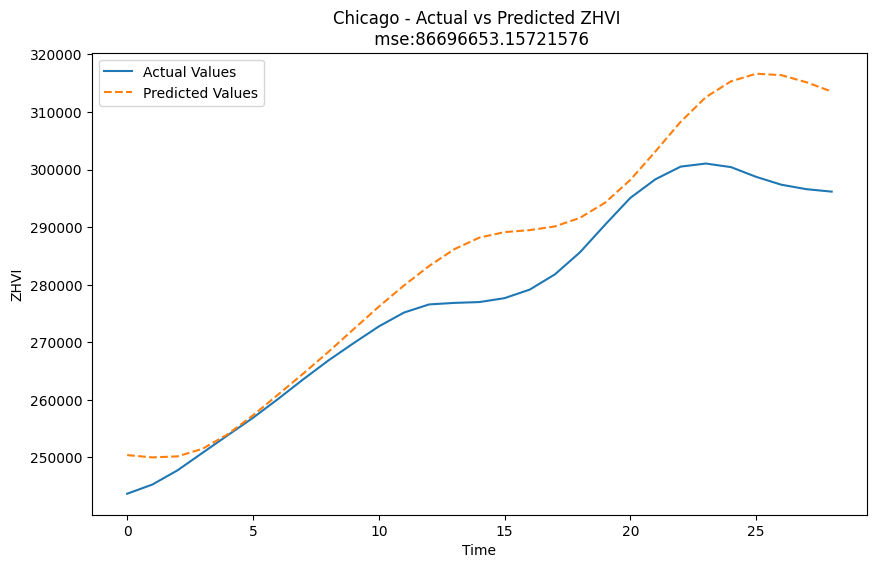

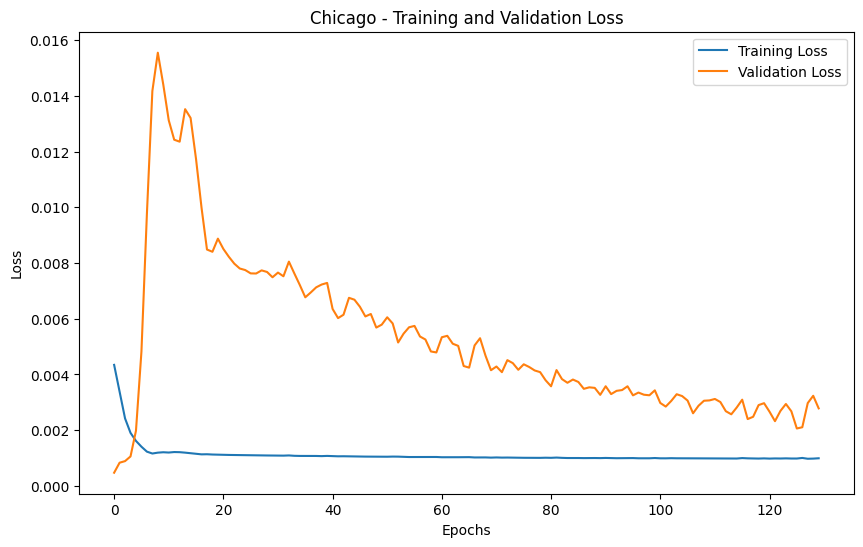

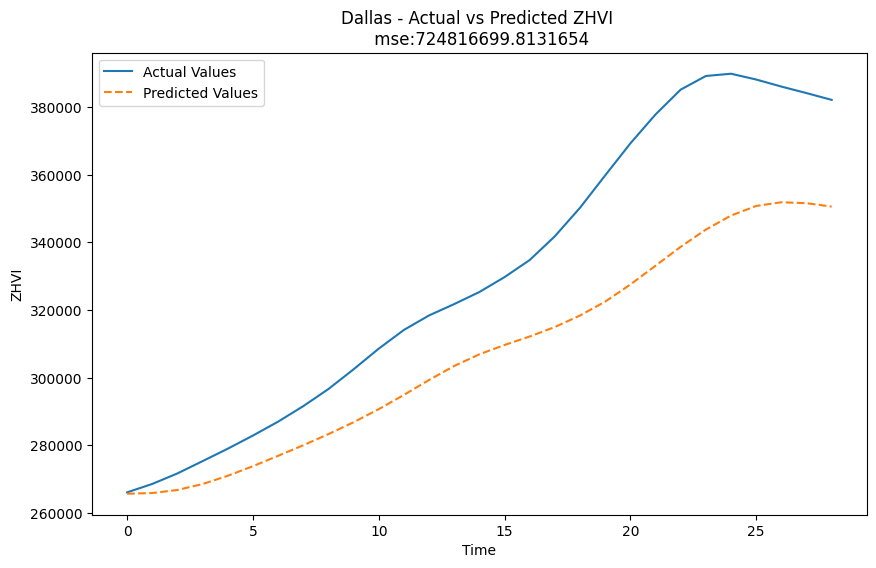

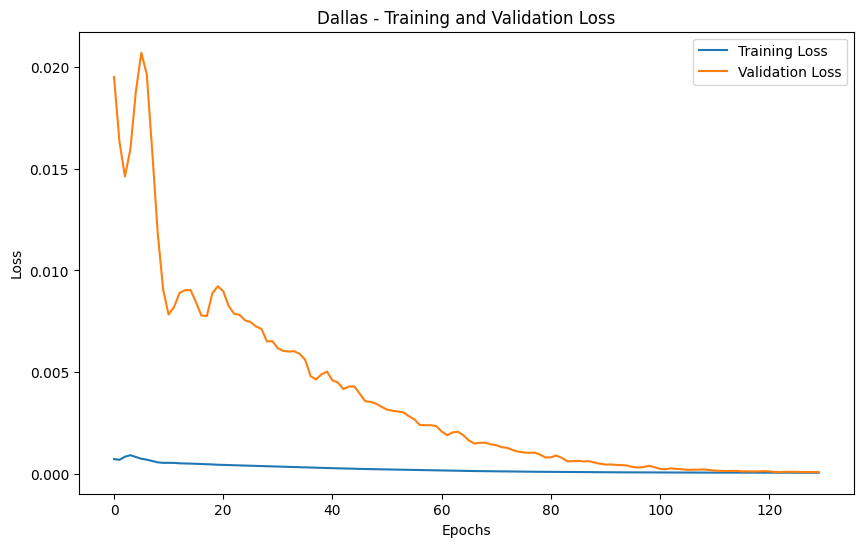

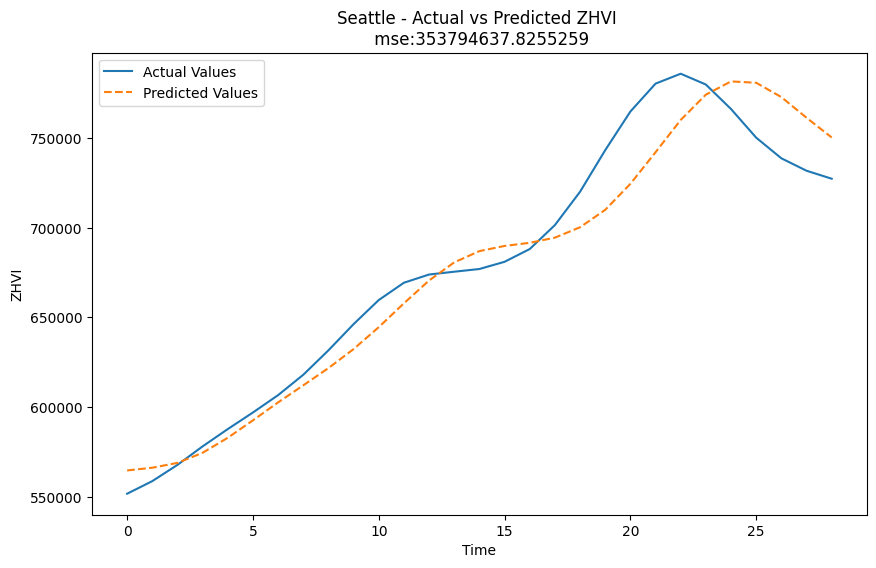

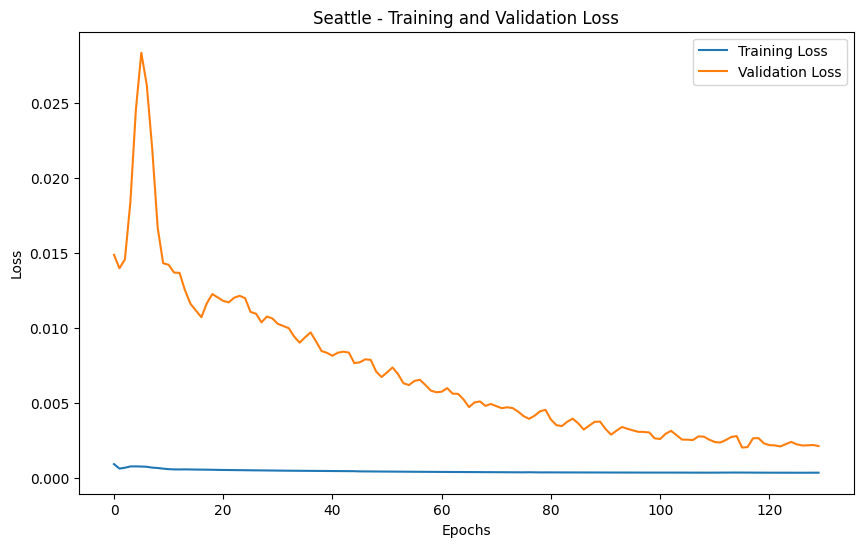

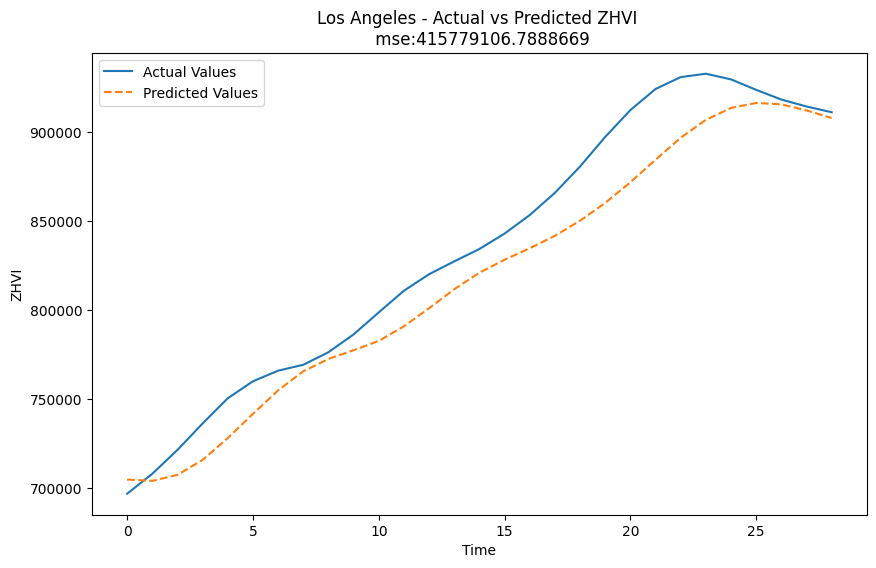

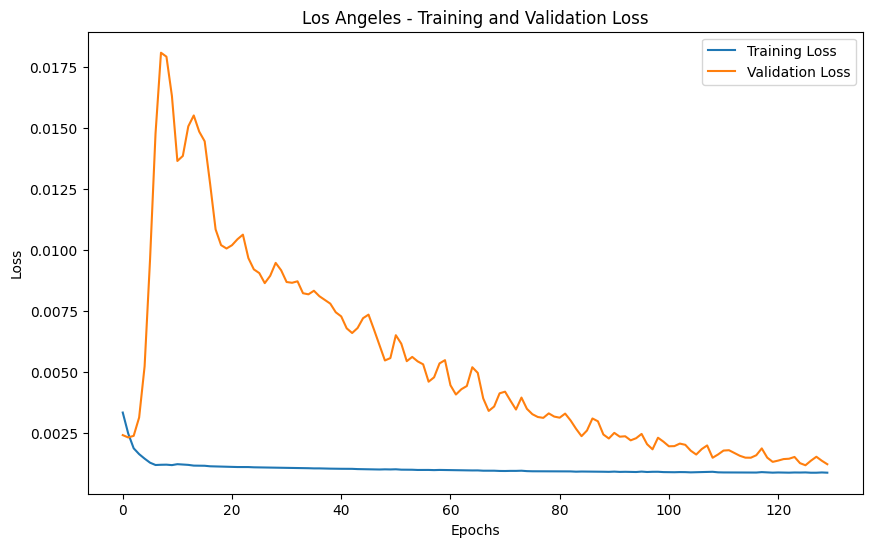

In [90]:
for idx, city in enumerate(cities):
  # Plotting the results
  plt.figure(figsize=(10, 6))
  plt.plot(results[city]['actuals'], label='Actual Values')
  plt.plot(results[city]['predictions'], label='Predicted Values', linestyle='--')
  plt.title(f"{city} - Actual vs Predicted ZHVI \n mse:{results[city]['mse']}")
  plt.xlabel('Time')
  plt.ylabel('ZHVI')
  plt.legend()
  plt.show()

  # Plotting loss curves
  plt.figure(figsize=(10, 6))
  plt.plot(results[city]['history'].history['loss'][20:], label='Training Loss')
  plt.plot(results[city]['history'].history['val_loss'][20:], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.title(f"{city} - Training and Validation Loss")
  plt.show()

In [91]:
comparison_dict = {}
for city in cities:
  city_mse = results[city]['mse']
  percent_change = ((city_mse - mse_result_mean_baseline[city])/mse_result_mean_baseline[city])*100
  comparison_dict[city] = percent_change
  print(f"For {city}, the model with fewer features and 3 month window size performed {'better' if percent_change < 0 else 'worse'} by {abs(percent_change):.2f}%")

print("\nSummary of Performance Changes Comparing to Mean Baseline Model:")
print(comparison_dict)

For Chicago, the model with fewer features and 3 month window size performed worse by 258.14%
For Dallas, the model with fewer features and 3 month window size performed worse by 603.34%
For Seattle, the model with fewer features and 3 month window size performed better by 28.12%
For Los Angeles, the model with fewer features and 3 month window size performed worse by 10.20%

Summary of Performance Changes Comparing to Mean Baseline Model:
{'Chicago': 258.13660686225603, 'Dallas': 603.3371626633252, 'Seattle': -28.1242010172216, 'Los Angeles': 10.20051824878559}


# <h1><center>Hyperprameter Tuning

In [19]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


In [20]:
# Import model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from kerastuner.tuners import RandomSearch
import shutil


<ipython-input-20-02407b722263>:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [21]:
# Clear the previous RandomSearch Result. RUN AS NEEDED
shutil.rmtree('hyperparam_tuning/lstm_tuning', ignore_errors=True)

In [22]:
# Filter data for Chicago only
city = "Chicago"
city_data = merged_df_filtered_feature[merged_df_filtered_feature['City'] == city].reset_index(drop=True)

# Function to preprocess the data
def preprocess_data(df, window=3):
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Preprocess data
X_train, y_train, X_test, y_test, scaler = preprocess_data(city_data, window=3)

# Build model function
def build_model(hp):
    model = Sequential()
    # First LSTM layer with Dropout
    model.add(LSTM(units=hp.Int('units_layer1', min_value=100, max_value=200, step=50),
                   return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2]),
                   kernel_regularizer=l2(hp.Float('l2_layer1', min_value=1e-4, max_value=1e-2, sampling='LOG'))))
    model.add(Dropout(rate=hp.Float('dropout_layer1', min_value=0.1, max_value=0.5, step=0.1)))

    # Second LSTM layer with Dropout
    model.add(LSTM(units=hp.Int('units_layer2', min_value=50, max_value=100, step=50),
                   kernel_regularizer=l2(hp.Float('l2_layer2', min_value=1e-4, max_value=1e-2, sampling='LOG'))))
    model.add(Dropout(rate=hp.Float('dropout_layer2', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1, kernel_regularizer=l2(hp.Float('l2_output', min_value=1e-4, max_value=1e-2, sampling='LOG'))))

    # Compile model
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

# Create tuner
tuner = RandomSearch(
    build_model,
    objective='val_loss',

    max_trials=100,
    executions_per_trial=2,
    directory='hyperparam_tuning',
    project_name='lstm_tuning_with_hub40')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Run the tuner search with early stopping
tuner.search(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])

Trial 100 Complete [00h 01m 06s]
val_loss: 0.006338519509881735

Best val_loss So Far: 0.002358013647608459
Total elapsed time: 01h 40m 42s


In [10]:
# Retrieve and print the best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:")
print(f"Units Layer 1: {best_hyperparameters.get('units_layer1')}")
print(f"Units Layer 2: {best_hyperparameters.get('units_layer2')}")
print(f"L2 Regularization Layer 1: {best_hyperparameters.get('l2_layer1')}")
print(f"L2 Regularization Layer 2: {best_hyperparameters.get('l2_layer2')}")
print(f"L2 Regularization Output Layer: {best_hyperparameters.get('l2_output')}")
print(f"Dropout Layer 1: {best_hyperparameters.get('dropout_layer1')}")
print(f"Dropout Layer 2: {best_hyperparameters.get('dropout_layer2')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")

# Extracting and printing the performance of different hyperparameter combinations
trials = tuner.oracle.get_best_trials(num_trials=10)
trial_data = []

for trial in trials:
    trial_data.append({
        'units_layer1': trial.hyperparameters.values['units_layer1'],
        'units_layer2': trial.hyperparameters.values['units_layer2'],
        'l2_layer1': trial.hyperparameters.values['l2_layer1'],
        'l2_layer2': trial.hyperparameters.values['l2_layer2'],
        'l2_output': trial.hyperparameters.values['l2_output'],
        'dropout_layer1': trial.hyperparameters.values['dropout_layer1'],
        'dropout_layer2': trial.hyperparameters.values['dropout_layer2'],
        'learning_rate': trial.hyperparameters.values['learning_rate'],
        'val_loss': trial.metrics.get_best_value('val_loss')
    })

trial_df = pd.DataFrame(trial_data)
print("\nTop 10 Hyperparameter Combinations:")
trial_df

Best Hyperparameters:
Units Layer 1: 150
Units Layer 2: 150
L2 Regularization Layer 1: 0.00011027153446879821
L2 Regularization Layer 2: 0.0002436074139531874
L2 Regularization Output Layer: 0.00011202631862509904
Dropout Layer 1: 0.30000000000000004
Dropout Layer 2: 0.4
Learning Rate: 0.009482039507425691

Top 10 Hyperparameter Combinations:


,units_layer1,units_layer2,l2_layer1,l2_layer2,l2_output,dropout_layer1,dropout_layer2,learning_rate,val_loss
0,150,150,0.000110,0.000244,0.000112,0.3,0.4,0.009482,0.002406
1,100,200,0.000216,0.000542,0.003121,0.1,0.1,0.003394,0.002745
2,100,200,0.001700,0.000551,0.000174,0.2,0.1,0.007256,0.002996
3,100,50,0.000796,0.001337,0.000268,0.2,0.2,0.002179,0.003384
4,50,100,0.000185,0.001886,0.000134,0.1,0.1,0.001265,0.003420
5,50,100,0.000109,0.000213,0.004210,0.1,0.5,0.007555,0.003543
6,150,150,0.000109,0.001263,0.000248,0.2,0.3,0.001398,0.003601
7,200,200,0.000168,0.000980,0.006217,0.5,0.5,0.001794,0.003796
8,100,100,0.000177,0.003260,0.001264,0.1,0.2,0.003755,0.003936
9,200,50,0.000542,0.000491,0.000960,0.1,0.1,0.001829,0.004137


In [11]:
# Build and retrain the best model
best_model = build_model(best_hyperparameters)
history = best_model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Function to make predictions and inverse scale them
def make_predictions(model, X, scaler):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2] - 1)))))
    return predictions[:, 0]  # Only return the ZHVI predictions

# Make predictions using the best model
lstm_preds = make_predictions(best_model, X_test, scaler)

y_test_inverse = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1)))))
actual_vals = y_test_inverse[:, 0]

# Calculate MSE
mse = mean_squared_error(actual_vals, lstm_preds)
print(f'Test MSE: {mse:.2f}')


Epoch 1/150


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - loss: 0.2626 - val_loss: 0.7699
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1791 - val_loss: 0.2375
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0810 - val_loss: 0.0617
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0815 - val_loss: 0.1471
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0601 - val_loss: 0.0463
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0488 - val_loss: 0.0609
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0422 - val_loss: 0.0414
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0379 - val_loss: 0.0528
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0330 - val_loss: 0.0239
Epoch 10/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0288 - val_loss: 0.0341
Epoch 11/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0270 - val_loss: 0.0305
Epoch 12/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0263 - val_loss: 0.0307


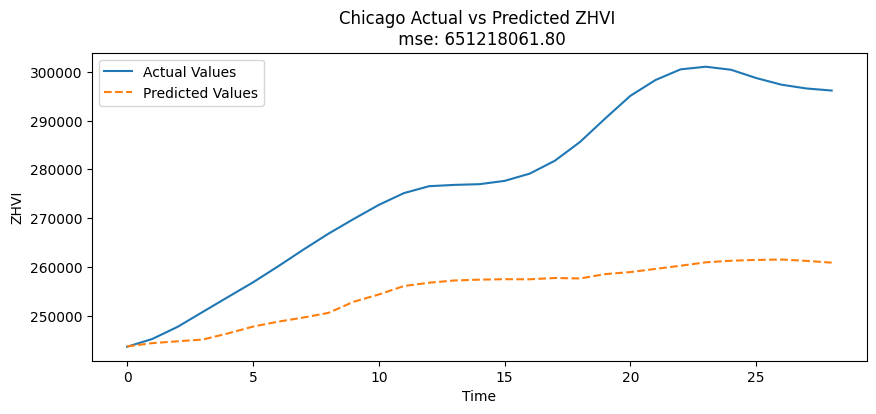

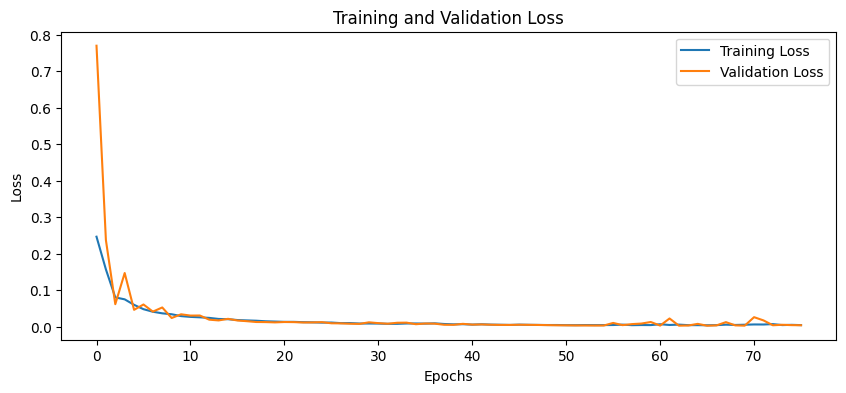

In [12]:

# Plotting the actual vs predicted results
plt.figure(figsize=(10, 4))
plt.plot(actual_vals, label='Actual Values')
plt.plot(lstm_preds, label='Predicted Values', linestyle='--')
plt.title(f"Chicago Actual vs Predicted ZHVI \n mse: {mse:.2f}")
plt.xlabel('Time')
plt.ylabel('ZHVI')
plt.legend()
plt.show()

# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

In [13]:
comparison_dict = {}
city = 'Chicago'
percent_change = ((mse - mse_result_mean_baseline[city])/mse_result_mean_baseline[city])*100
comparison_dict[city] = percent_change
print(f"For {city}, the model with fewer features and 3 month window size performed {'better' if percent_change < 0 else 'worse'} by {abs(percent_change):.2f}%")

print("\nSummary of Performance Changes Comparing to Mean Baseline Model:")
print(comparison_dict)

For Chicago, the model with fewer features and 3 month window size performed worse by 2590.13%

Summary of Performance Changes Comparing to Mean Baseline Model:
{'Chicago': 2590.127225055784}
